#### 1. importing libraries and reading the data

In [1]:
import os # for file manipulation only
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# for organization, the imports are going to be in-place
from keras.models import Sequential, load_model
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.losses import MeanSquaredError, MeanAbsoluteError
from keras.optimizers import Adam, Nadam
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

2024-06-12 12:50:13.041264: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 12:50:13.041336: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 12:50:13.087867: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-12 12:50:13.180951: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 12:50:14.123522: W tensorflow/compiler/tf2

In [2]:
# loading the dataset:
dataset = pd.read_csv('./jena_climate_2009_2016.csv')

dataset.index = dataset['Date Time']

dataset.drop('Date Time', axis=1, inplace=True)

dataset.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


#### 2 and 3. selecting and splitting the data on train, test and validation sets

In [3]:
# filtering only data that shall be used (temperature, in Celsius, every hour)
temperatures = dataset['T (degC)'][5::6]
print(temperatures.shape)

# normalizing it
scaler = MinMaxScaler()
norm_temps = scaler.fit_transform(temperatures.values.reshape(-1, 1))
print(scaler.data_max_, scaler.data_min_)

(70091,)
[37.28] [-22.76]


In [5]:
# defining a function to help creating the x, y pairs of features and targets

def data_to_xy(arr, feature_size: int, target_size: int):
    """
        Creates sets of training and target datapoints, with sizes defined by the features and targets parameters.

        returns a tuple of (training_data, target_data), with length equal to: (len(arr) - features - targets + 1), in ndarray format.
    """
    train = []
    target = []

    for i in range(feature_size, arr.shape[0] - target_size + 1):
        train.append(np.array(arr[i-feature_size:i, 0]))
        target.append(np.array(arr[i:i+target_size, 0]))

    train = np.stack(train)
    target = np.stack(target)

    return train, target

# splitting the data into training and test sets
train, test = train_test_split(norm_temps, test_size=0.2, shuffle=False)
val, test = train_test_split(test, test_size=0.25, shuffle=False)


#### 4. defining a model to predict the next hour, based on the previous 24 hours

In [7]:
# defining the initial model approach
f = 24 # taking up the previous 24h
t = 1 # predicting the next 1h

model4 = Sequential()
model4.add(InputLayer((f, 1)))
model4.add(LSTM(64))
model4.add(Dense(8, activation='relu'))
model4.add(Dense(t, activation='sigmoid'))

model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [179]:
cp = ModelCheckpoint('best_model4.keras', save_best_only=True)
model4.compile(optimizer=Adam(0.0001),
               loss=MeanSquaredError())
            #    metrics=['root_mean_squared_error'])

Epoch 1/20
1752/1752 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0019
Epoch 2/20
1752/1752 [==============================] - 6s 3ms/step - loss: 0.0011 - val_loss: 9.4433e-04
Epoch 3/20
1752/1752 [==============================] - 6s 3ms/step - loss: 6.8550e-04 - val_loss: 7.9728e-04
Epoch 4/20
1752/1752 [==============================] - 6s 4ms/step - loss: 5.3993e-04 - val_loss: 5.0249e-04
Epoch 5/20
1752/1752 [==============================] - 6s 3ms/step - loss: 4.5691e-04 - val_loss: 4.3318e-04
Epoch 6/20
1752/1752 [==============================] - 6s 3ms/step - loss: 3.9727e-04 - val_loss: 4.2842e-04
Epoch 7/20
1752/1752 [==============================] - 6s 4ms/step - loss: 3.4835e-04 - val_loss: 3.3832e-04
Epoch 8/20
1752/1752 [==============================] - 6s 3ms/step - loss: 3.0748e-04 - val_loss: 3.0442e-04
Epoch 9/20
1752/1752 [==============================] - 7s 4ms/step - loss: 2.7933e-04 - val_loss: 3.2946e-04
Epoch 10/20
1752/1752 

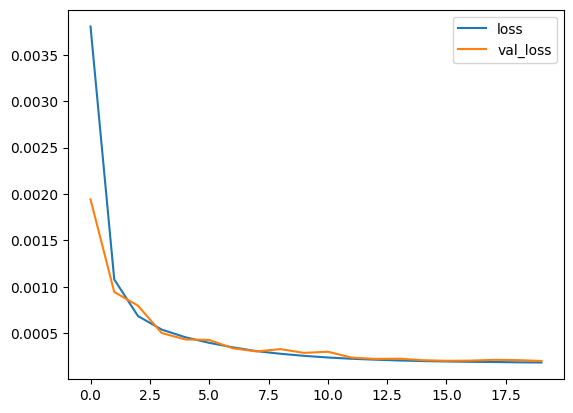

In [188]:
train_x, train_y = data_to_xy(train, f, t)

history1 = model4.fit(train_x, train_y, 
           validation_data=data_to_xy(val, f, t),
           epochs=20,
           callbacks=[cp],
           verbose=1)

plt.plot(history1.history['loss'], label='loss')
plt.plot(history1.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

109/109 [==============================] - 0s 1ms/step


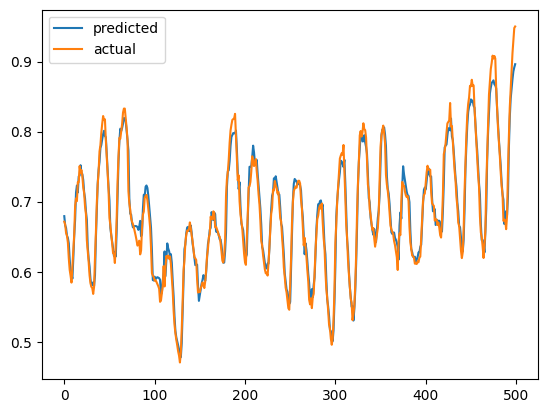

Mean Absolute Error over testing data: 0.009552299993369068
and that averages to a 0.57 degrees error


In [176]:
# testing out the trained model on the (up to now) unseen test data
test_x, test_y = data_to_xy(test, f, t)

load_model('best_model4.keras')
preds = model4.predict(test_x)

plt.plot(preds[0:500], label='predicted')
plt.plot(test_y[0:500], label='actual')
plt.legend()
plt.show()

# printing the errors
mae = mean_absolute_error(test_y, preds)
print(f"Mean Absolute Error over testing data: {mae}")
avg_error = scaler.inverse_transform([[mae]])[0][0] - scaler.data_min_[0]
print(f"and that averages to a {avg_error:.2f} degrees error")

As it can be seem, the initial approach had quite a good performance for such a small training period.


#### 5. Tweaking hyperparameters

##### defining a helper function to create the model

In [8]:
# first of all, let's create a helper function to train, test and plot the results of the models

def train_test_plot(model,
                    train = data_to_xy(train, f, t),
                    val = data_to_xy(val, f, t),
                    test = data_to_xy(test, f, t),
                    optimizer = Adam(0.0001),
                    loss = MeanSquaredError(),
                    metrics = ['mean_absolute_error'],
                    epochs = 20,
                    bool_plot_result = True,
                    ):
    PATH_TO_MODEL = 'best_model_5.keras'
    cp = ModelCheckpoint(PATH_TO_MODEL, save_best_only=True)
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=metrics)
    
    history = model.fit(train[0], train[1], 
                        validation_data=val,
                        epochs=epochs,
                        callbacks=[cp],
                        verbose=1)

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

    loaded_model = load_model(PATH_TO_MODEL)
    os.remove(PATH_TO_MODEL)
    
    preds = loaded_model.predict(test[0])

    if(bool_plot_result):
        plt.plot(preds[0:200], label='predicted')
        plt.plot(test[1][0:200], label='actual')
        plt.legend()
        plt.show()
    
    # printing the errors
    mae = mean_absolute_error(test[1], preds)
    print(f"Mean Absolute Error over testing data: {mae}")
    avg_error = scaler.inverse_transform([[mae]])[0][0] - scaler.data_min_[0]
    print(f"and that averages to a {avg_error:.2f} degrees error")
    
    return loaded_model


##### 5.a Decreasing the number of LSTM units on a layer

In [165]:
# first, let's play with the size of the LSTM layer
model5a = Sequential()
model5a.add(InputLayer((f, 1)))
model5a.add(LSTM(16))
model5a.add(Dense(8, activation='relu'))
model5a.add(Dense(t, activation='sigmoid'))
model5a.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 16)                1152      
                                                                 
 dense_54 (Dense)            (None, 8)                 136       
                                                                 
 dense_55 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1297 (5.07 KB)
Trainable params: 1297 (5.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/20
1752/1752 [==============================] - 7s 3ms/step - loss: 0.0097 - mean_absolute_error: 0.0752 - val_loss: 0.0037 - val_mean_absolute_error: 0.0476
Epoch 2/20
1752/1752 [==============================] - 6s 3ms/step - loss: 0.0036 - mean_absolute_error: 0.0464 - val_loss: 0.0029 - val_mean_absolute_error: 0.0429
Epoch 3/20
1752/1752 [==============================] - 6s 3ms/step - loss: 0.0027 - mean_absolute_error: 0.0410 - val_loss: 0.0025 - val_mean_absolute_error: 0.0391
Epoch 4/20
1752/1752 [==============================] - 6s 4ms/step - loss: 0.0022 - mean_absolute_error: 0.0366 - val_loss: 0.0019 - val_mean_absolute_error: 0.0340
Epoch 5/20
1752/1752 [==============================] - 6s 3ms/step - loss: 0.0015 - mean_absolute_error: 0.0305 - val_loss: 0.0012 - val_mean_absolute_error: 0.0269
Epoch 6/20
1752/1752 [==============================] - 6s 3ms/step - loss: 0.0010 - mean_absolute_error: 0.0241 - val_loss: 8.5665e-04 - val_mean_absolute_error: 0.0222


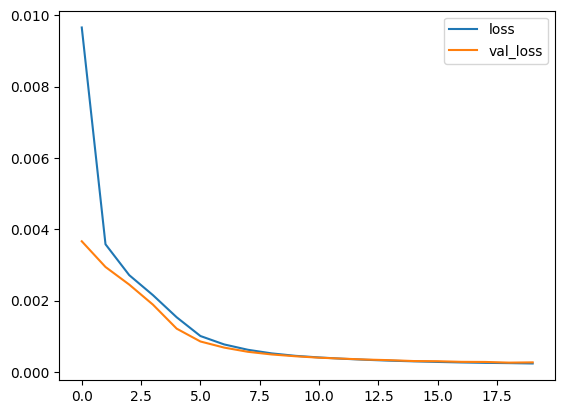

109/109 [==============================] - 0s 1ms/step


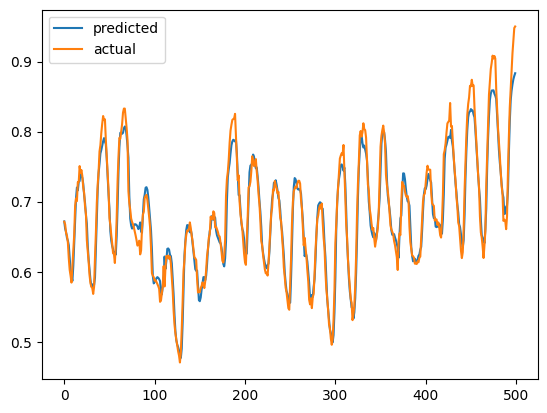

Mean Absolute Error over testing data: 0.010325865769435656
and that averages to a 0.62 degrees error


In [168]:
# training, testing and plotting the results
train_test_plot(model5a, optimizer=Adam(0.0001))

As it can be seem from this first alternative approach, the model already has quite good performance, with even smaller training time required, which makes it a good alternative.

##### 5.b Inserting Dropout layers

In [177]:
# defining a new model, for the same task, with dropout layers

model5b = Sequential()
model5b.add(InputLayer((f, 1)))
model5b.add(LSTM(64))
model5b.add(Dropout(0.3))
model5b.add(Dense(8, activation='relu'))
model5b.add(Dense(t, activation='sigmoid'))
model5b.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 64)                16896     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_62 (Dense)            (None, 8)                 520       
                                                                 
 dense_63 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/20
1752/1752 [==============================] - 8s 4ms/step - loss: 0.0061 - mean_absolute_error: 0.0588 - val_loss: 0.0033 - val_mean_absolute_error: 0.0457
Epoch 2/20
1752/1752 [==============================] - 6s 4ms/step - loss: 0.0032 - mean_absolute_error: 0.0448 - val_loss: 0.0026 - val_mean_absolute_error: 0.0396
Epoch 3/20
1752/1752 [==============================] - 6s 4ms/step - loss: 0.0019 - mean_absolute_error: 0.0338 - val_loss: 0.0012 - val_mean_absolute_error: 0.0265
Epoch 4/20
1752/1752 [==============================] - 6s 4ms/step - loss: 0.0013 - mean_absolute_error: 0.0281 - val_loss: 9.6261e-04 - val_mean_absolute_error: 0.0237
Epoch 5/20
1752/1752 [==============================] - 6s 4ms/step - loss: 0.0010 - mean_absolute_error: 0.0248 - val_loss: 7.2514e-04 - val_mean_absolute_error: 0.0203
Epoch 6/20
1752/1752 [==============================] - 6s 4ms/step - loss: 8.3878e-04 - mean_absolute_error: 0.0220 - val_loss: 5.4654e-04 - val_mean_absolute_er

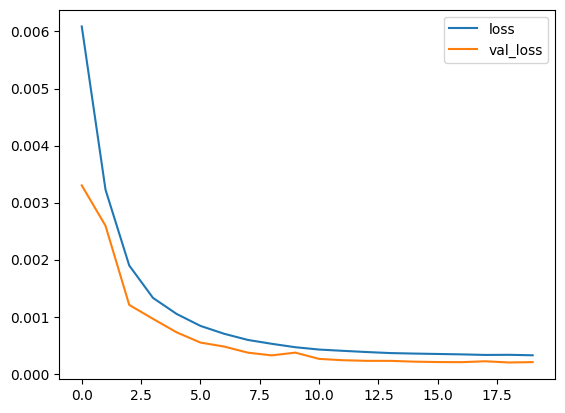

109/109 [==============================] - 0s 1ms/step


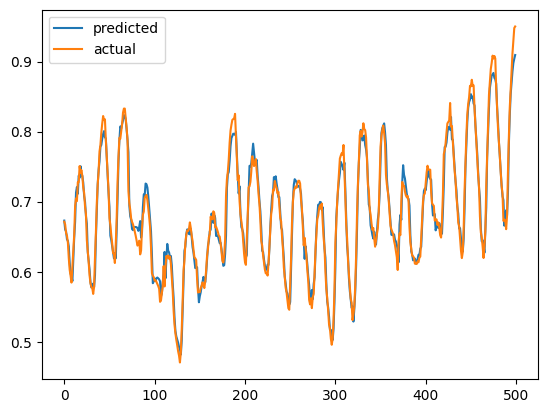

Mean Absolute Error over testing data: 0.008629685457024756
and that averages to a 0.52 degrees error


In [182]:
# testing out the trained model on the (up to now) unseen test data
train_test_plot(model5b, optimizer=Adam(0.0001))

As it can be seem, the performace had a slight improvement on fitting the test set, but the validation and training sets had a slight decrease in performance, which may indicate that the model was overfitting the training set, and the dropout layers helped to prevent that.


##### 5.c Altering the optimizer

In [184]:
# defining a model like the previous one, but with a different optimizer
model5c = Sequential()
model5c.add(InputLayer((f, 1)))
model5c.add(LSTM(64))
model5c.add(Dense(8, activation='relu'))
model5c.add(Dense(t, activation='sigmoid'))
model5c.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 64)                16896     
                                                                 
 dense_66 (Dense)            (None, 8)                 520       
                                                                 
 dense_67 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/20
1752/1752 [==============================] - 9s 4ms/step - loss: 0.0051 - mean_absolute_error: 0.0536 - val_loss: 0.0030 - val_mean_absolute_error: 0.0437
Epoch 2/20
1752/1752 [==============================] - 7s 4ms/step - loss: 0.0023 - mean_absolute_error: 0.0371 - val_loss: 0.0015 - val_mean_absolute_error: 0.0296
Epoch 3/20
1752/1752 [==============================] - 6s 4ms/step - loss: 0.0012 - mean_absolute_error: 0.0263 - val_loss: 0.0010 - val_mean_absolute_error: 0.0241
Epoch 4/20
1752/1752 [==============================] - 6s 4ms/step - loss: 7.6497e-04 - mean_absolute_error: 0.0209 - val_loss: 6.6107e-04 - val_mean_absolute_error: 0.0191
Epoch 5/20
1752/1752 [==============================] - 6s 4ms/step - loss: 5.5361e-04 - mean_absolute_error: 0.0175 - val_loss: 5.3135e-04 - val_mean_absolute_error: 0.0171
Epoch 6/20
1752/1752 [==============================] - 6s 4ms/step - loss: 4.5237e-04 - mean_absolute_error: 0.0157 - val_loss: 4.4101e-04 - val_mean_abs

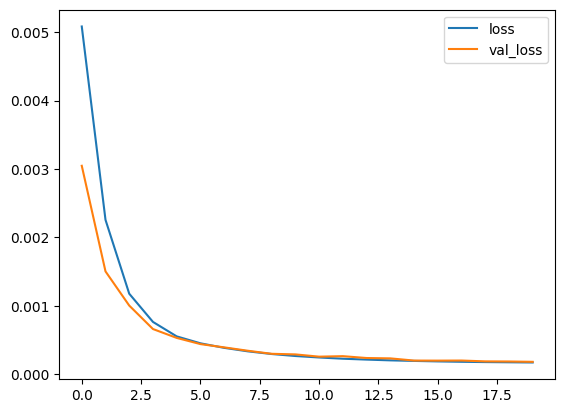

109/109 [==============================] - 0s 1ms/step


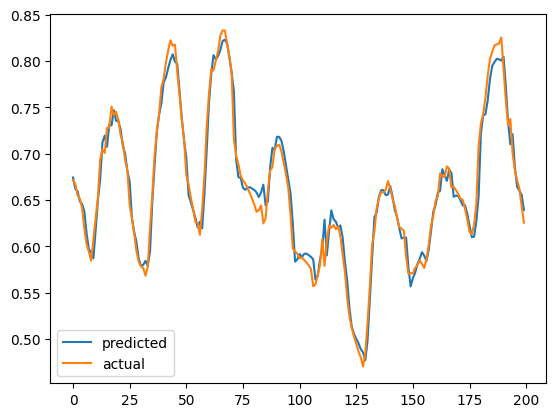

Mean Absolute Error over testing data: 0.0081861523860475
and that averages to a 0.49 degrees error


In [185]:
# training, testing and plotting the results with the new optimizer
train_test_plot(model5c, optimizer=Nadam(0.0001))

It can be seem that the new optimizer had improved velocity on fitting the training set, which may indicate that the model is learning faster, which makes the overall performance better.

##### 5.d Altering the loss function

In [186]:
# defining the model
model5d = Sequential()
model5d.add(InputLayer((f, 1)))
model5d.add(LSTM(64))
model5d.add(Dense(8, activation='relu'))
model5d.add(Dense(t, activation='sigmoid'))
model5d.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_37 (LSTM)              (None, 64)                16896     
                                                                 
 dense_68 (Dense)            (None, 8)                 520       
                                                                 
 dense_69 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/20
1752/1752 [==============================] - 7s 4ms/step - loss: 0.0560 - mean_squared_error: 0.0056 - val_loss: 0.0434 - val_mean_squared_error: 0.0031
Epoch 2/20
1752/1752 [==============================] - 6s 3ms/step - loss: 0.0375 - mean_squared_error: 0.0023 - val_loss: 0.0305 - val_mean_squared_error: 0.0017
Epoch 3/20
1752/1752 [==============================] - 6s 3ms/step - loss: 0.0278 - mean_squared_error: 0.0013 - val_loss: 0.0263 - val_mean_squared_error: 0.0012
Epoch 4/20
1752/1752 [==============================] - 5s 3ms/step - loss: 0.0238 - mean_squared_error: 9.7835e-04 - val_loss: 0.0240 - val_mean_squared_error: 9.6869e-04
Epoch 5/20
1752/1752 [==============================] - 6s 3ms/step - loss: 0.0206 - mean_squared_error: 7.5786e-04 - val_loss: 0.0231 - val_mean_squared_error: 8.6547e-04
Epoch 6/20
1752/1752 [==============================] - 6s 3ms/step - loss: 0.0184 - mean_squared_error: 6.1903e-04 - val_loss: 0.0177 - val_mean_squared_error: 5.9

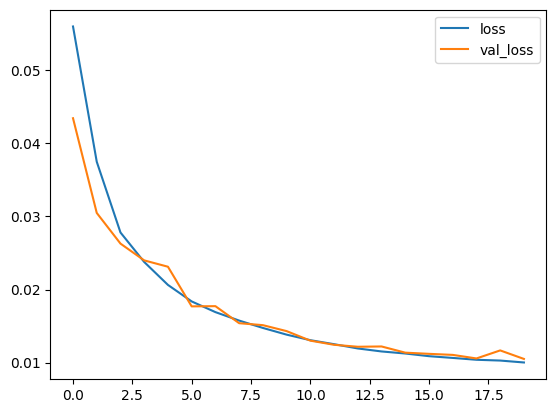

109/109 [==============================] - 0s 1ms/step


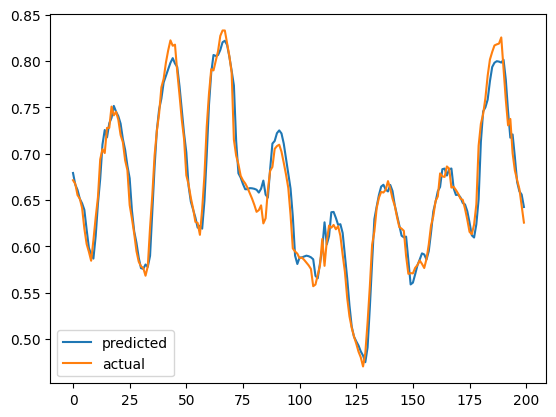

Mean Absolute Error over testing data: 0.009150686921893355
and that averages to a 0.55 degrees error


In [187]:
# training, testing and plotting the results with the new optimizer
train_test_plot(model5d, loss=MeanAbsoluteError(), metrics=['mean_squared_error'])

By altering the loss function, we can see that the model converges a little faster, effect that may be compared to increasing the learning rate. Despite that, the performance didn't improve that much.

#### 6. messing with the windowing size

#### 6.a Decreasing the window size

In [192]:
f = 6 # taking up the previous 6h
t = 1 # predicting the next 1h

# defining the model
model6a = Sequential()
model6a.add(InputLayer((f, 1)))
model6a.add(LSTM(64))
model6a.add(Dropout(0.3)) # using dropout on this section models
model6a.add(Dense(8, activation='relu'))
model6a.add(Dense(t, activation='sigmoid'))
model6a.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 64)                16896     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_72 (Dense)            (None, 8)                 520       
                                                                 
 dense_73 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/20
1753/1753 [==============================] - 8s 4ms/step - loss: 0.0062 - mean_absolute_error: 0.0579 - val_loss: 0.0028 - val_mean_absolute_error: 0.0390
Epoch 2/20
1753/1753 [==============================] - 6s 3ms/step - loss: 0.0026 - mean_absolute_error: 0.0389 - val_loss: 0.0020 - val_mean_absolute_error: 0.0340
Epoch 3/20
1753/1753 [==============================] - 6s 3ms/step - loss: 0.0019 - mean_absolute_error: 0.0328 - val_loss: 0.0011 - val_mean_absolute_error: 0.0235
Epoch 4/20
1753/1753 [==============================] - 6s 3ms/step - loss: 0.0011 - mean_absolute_error: 0.0242 - val_loss: 7.7170e-04 - val_mean_absolute_error: 0.0198
Epoch 5/20
1753/1753 [==============================] - 6s 3ms/step - loss: 8.1806e-04 - mean_absolute_error: 0.0211 - val_loss: 5.7649e-04 - val_mean_absolute_error: 0.0171
Epoch 6/20
1753/1753 [==============================] - 6s 3ms/step - loss: 7.2279e-04 - mean_absolute_error: 0.0197 - val_loss: 5.1367e-04 - val_mean_absolut

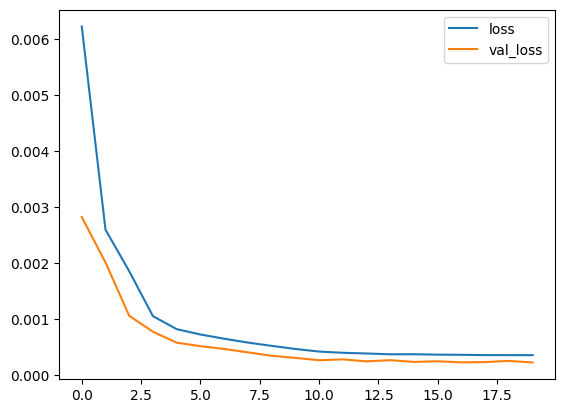

110/110 [==============================] - 0s 1ms/step


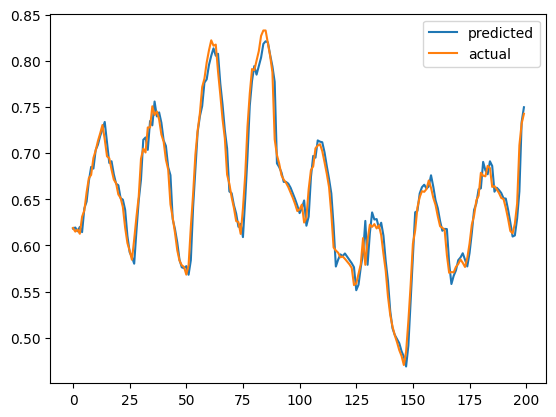

Mean Absolute Error over testing data: 0.009531923047113065
and that averages to a 0.57 degrees error


In [193]:
# training, testing and plotting the results with the new windowing
train_test_plot(model6a, optimizer=Nadam(0.0001), train=data_to_xy(train, f, t), val=data_to_xy(val, f, t), test=data_to_xy(test, f, t))

As seem, the model had a very slight decrease in performance, even though the training got a little faster, which may indicate either:
- that the model can't handle long information windows.
- that the model is capable of learning the patterns even with a smaller window size.

#### 6.b Increasing the window size

In [28]:
f = 72 # taking up the previous 3 days
t = 1 # predicting the next 1h

# defining the model
model6b = Sequential()
model6b.add(InputLayer((f, 1)))
model6b.add(LSTM(64))
model6b.add(Dropout(0.3))
model6b.add(Dense(8, activation='relu'))
model6b.add(Dense(t, activation='sigmoid'))
model6b.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/20
1750/1750 [==============================] - 10s 5ms/step - loss: 0.0070 - mean_absolute_error: 0.0638 - val_loss: 0.0040 - val_mean_absolute_error: 0.0494
Epoch 2/20
1750/1750 [==============================] - 8s 5ms/step - loss: 0.0039 - mean_absolute_error: 0.0486 - val_loss: 0.0034 - val_mean_absolute_error: 0.0457
Epoch 3/20
1750/1750 [==============================] - 8s 4ms/step - loss: 0.0030 - mean_absolute_error: 0.0426 - val_loss: 0.0012 - val_mean_absolute_error: 0.0265
Epoch 4/20
1750/1750 [==============================] - 8s 4ms/step - loss: 0.0013 - mean_absolute_error: 0.0275 - val_loss: 7.4282e-04 - val_mean_absolute_error: 0.0205
Epoch 5/20
1750/1750 [==============================] - 8s 4ms/step - loss: 9.6344e-04 - mean_absolute_error: 0.0238 - val_loss: 7.2717e-04 - val_mean_absolute_error: 0.0211
Epoch 6/20
1750/1750 [==============================] - 8s 5ms/step - loss: 8.1879e-04 - mean_absolute_error: 0.0217 - val_loss: 5.2092e-04 - val_mean_absolu

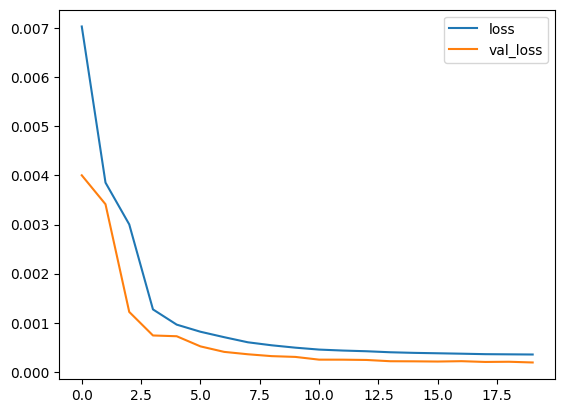

108/108 [==============================] - 0s 2ms/step


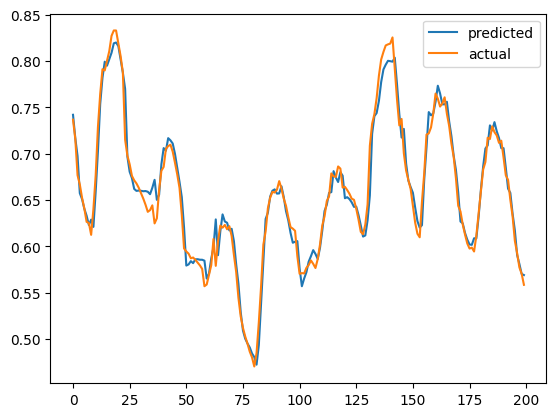

Mean Absolute Error over testing data: 0.00861756734929223
and that averages to a 0.52 degrees error


In [29]:
# training, testing and plotting the results with the new windowing
train_test_plot(model6b, optimizer=Nadam(0.0001), train=data_to_xy(train, f, t), val=data_to_xy(val, f, t), test=data_to_xy(test, f, t))

On the other hand, increasing the window size brought a slight increase in performance, which may indicate the model is capable of using long term information, even though it isn't necessary for this specific problem. By taking a look at the training time, by the way, it is notable that smaller windows (for next-hour predictions) are better.

#### 7. Trying to reduce the dataset

In [27]:
# redefining train, val and test sets
temperatures7 = dataset['T (degC)']['01.01.2015 00:00:00'::6]
print(temperatures7.shape)
norm_temps7 = scaler.fit_transform(temperatures7.values.reshape(-1, 1))

train7, test7 = train_test_split(norm_temps7, test_size=0.2, shuffle=False)
val7, test7 = train_test_split(test7, test_size=0.25, shuffle=False)

(17470,)


In [31]:
# defining a model similar to our basis on section 4
model7 = Sequential()
model7.add(InputLayer((f, 1)))
model7.add(LSTM(64))
model7.add(Dense(8, activation='relu'))
model7.add(Dense(t, activation='sigmoid'))
model7.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                16896     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/50
436/436 [==============================] - 8s 11ms/step - loss: 0.0128 - mean_absolute_error: 0.0871 - val_loss: 0.0052 - val_mean_absolute_error: 0.0568
Epoch 2/50
436/436 [==============================] - 3s 8ms/step - loss: 0.0053 - mean_absolute_error: 0.0579 - val_loss: 0.0048 - val_mean_absolute_error: 0.0546
Epoch 3/50
436/436 [==============================] - 2s 4ms/step - loss: 0.0050 - mean_absolute_error: 0.0559 - val_loss: 0.0046 - val_mean_absolute_error: 0.0541
Epoch 4/50
436/436 [==============================] - 4s 10ms/step - loss: 0.0047 - mean_absolute_error: 0.0543 - val_loss: 0.0043 - val_mean_absolute_error: 0.0515
Epoch 5/50
436/436 [==============================] - 4s 10ms/step - loss: 0.0045 - mean_absolute_error: 0.0530 - val_loss: 0.0041 - val_mean_absolute_error: 0.0502
Epoch 6/50
436/436 [==============================] - 4s 10ms/step - loss: 0.0043 - mean_absolute_error: 0.0516 - val_loss: 0.0039 - val_mean_absolute_error: 0.0484
Epoch 7/50
4

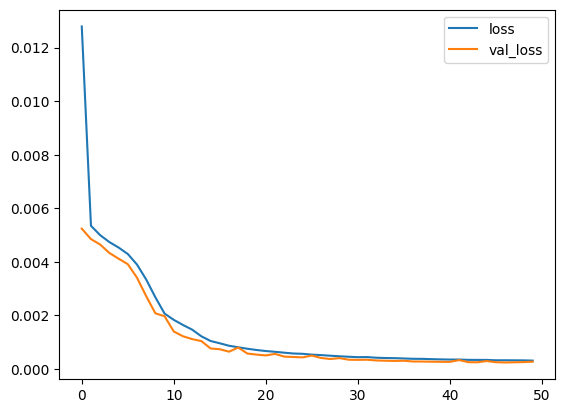

27/27 [==============================] - 1s 3ms/step


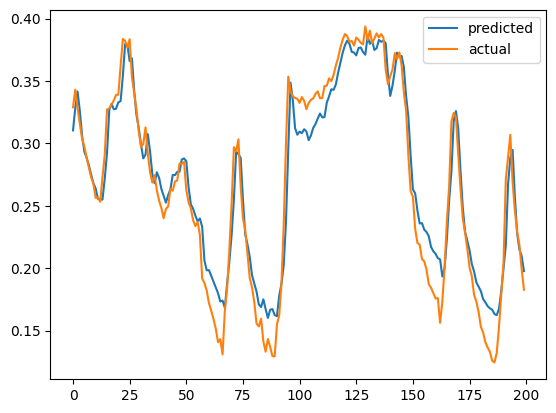

Mean Absolute Error over testing data: 0.01302172503050291
and that averages to a 0.66 degrees error


In [32]:
# training, testing and plotting the results with the new dataset
train_test_plot(model7, optimizer=Adam(0.0001),
                train=data_to_xy(train7, f, t),
                val=data_to_xy(val7, f, t),
                test=data_to_xy(test7, f, t),
                epochs=50)

As it can be seem from the above graphs, and as expected, the model had a major negative impact on performance, with almost the triple epochs being needed for it to achieve the same performance as the original model.

It's worth noting, nonetheless, that there are two principal kinds of time sections:
- the pretty stable ones, where the model can learn the patterns and predict the next hour with an excellent performance, (not very different from all the other models trained).
- the ones with lots of variation, where specially this model had a hard time, given that there aren't many patterns to learn from on the limited training set.

#### 8. trying to predict the entire next day, based on the last 7 days

In [9]:
# redefining the feature-target sizing
f3 = 7*24
t3 = 24

In [17]:
# creating a new model with the new feature-target sizing
model_day = Sequential()
model_day.add(InputLayer((f3, 1)))
model_day.add(LSTM(64, return_sequences=True))
model_day.add(LSTM(64))
model_day.add(Dropout(0.3))
model_day.add(Dense(64, activation='relu'))
model_day.add(Dense(t3, activation='sigmoid'))
model_day.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 168, 64)           16896     
                                                                 
 lstm_6 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 24)                1560      
                                                                 
Total params: 55640 (217.34 KB)
Trainable params: 55640 (217.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/20
1747/1747 [==============================] - 24s 12ms/step - loss: 0.0068 - mean_absolute_error: 0.0634 - val_loss: 0.0046 - val_mean_absolute_error: 0.0525
Epoch 2/20
1747/1747 [==============================] - 20s 11ms/step - loss: 0.0045 - mean_absolute_error: 0.0526 - val_loss: 0.0042 - val_mean_absolute_error: 0.0513
Epoch 3/20
1747/1747 [==============================] - 20s 11ms/step - loss: 0.0036 - mean_absolute_error: 0.0470 - val_loss: 0.0030 - val_mean_absolute_error: 0.0428
Epoch 4/20
1747/1747 [==============================] - 21s 12ms/step - loss: 0.0028 - mean_absolute_error: 0.0417 - val_loss: 0.0028 - val_mean_absolute_error: 0.0407
Epoch 5/20
1747/1747 [==============================] - 21s 12ms/step - loss: 0.0027 - mean_absolute_error: 0.0402 - val_loss: 0.0025 - val_mean_absolute_error: 0.0384
Epoch 6/20
1747/1747 [==============================] - 20s 11ms/step - loss: 0.0026 - mean_absolute_error: 0.0395 - val_loss: 0.0025 - val_mean_absolute_error:

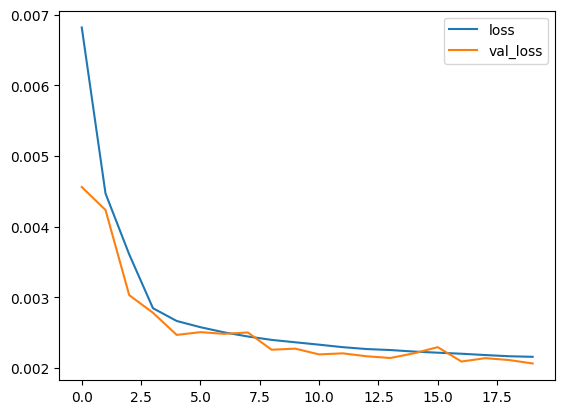

104/104 [==============================] - 1s 4ms/step
Mean Absolute Error over testing data: 0.031724305995793844
and that averages to a 1.90 degrees error


In [18]:
# using the best/fastest configurations from other models
foo = train_test_plot(model_day,
                      optimizer=Nadam(0.0001),
                      train=data_to_xy(train, f3, t3),
                      val=data_to_xy(val, f3, t3),
                      test=data_to_xy(test, f3, t3),
                      bool_plot_result=False)

104/104 [==============================] - 0s 4ms/step


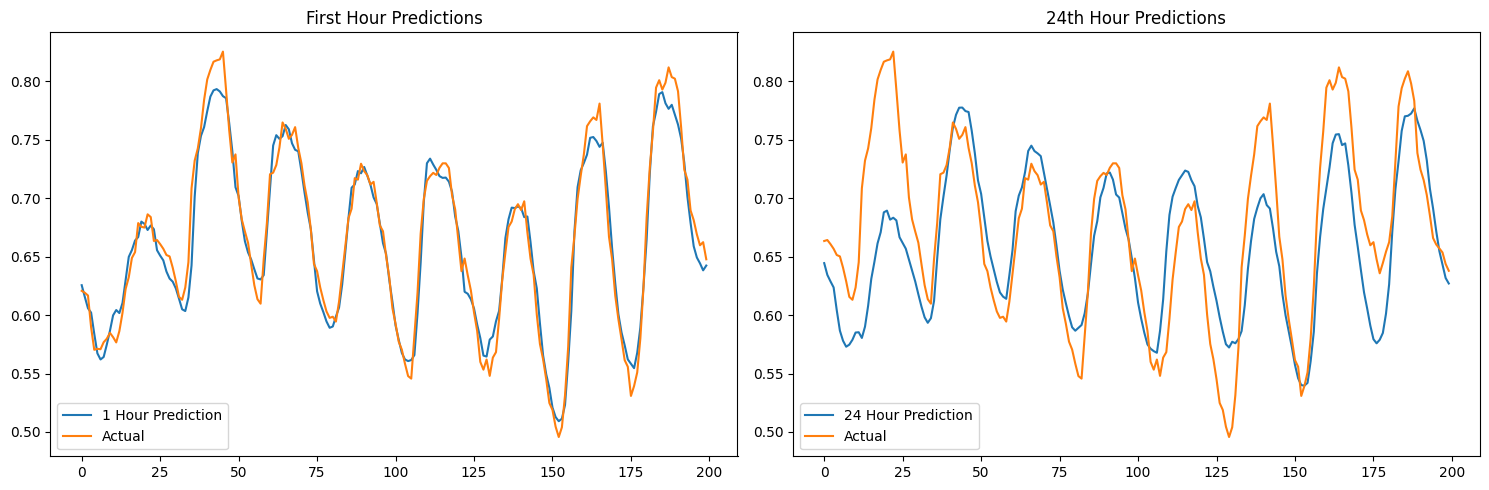

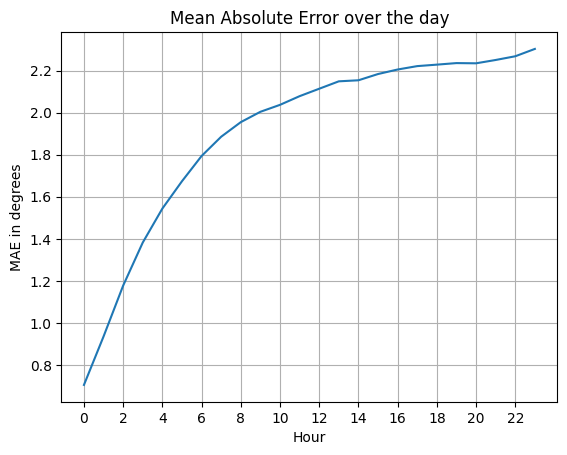

In [35]:
# doing some analysis on the trained model
test_x, test_y = data_to_xy(test, f3, t3)
preds7 = foo.predict(test_x)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(preds7[0:200, 0], label='1 Hour Prediction')
axs[0].plot(test_y[0:200, 0], label='Actual')
axs[0].set_title('First Hour Predictions')
axs[0].legend()

# Plot the 24th hour predictions
axs[1].plot(preds7[0:200, 23], label='24 Hour Prediction')
axs[1].plot(test_y[0:200, 23], label='Actual')
axs[1].set_title('24th Hour Predictions')
axs[1].legend()


plt.tight_layout()
plt.show()

# mae analysis over the day long predictions
maes = []
for i in range(24):
    mae = mean_absolute_error(test_y[:, i], preds7[:, i])
    avg_error = scaler.inverse_transform([[mae]])[0][0] - scaler.data_min_[0]
    maes.append(avg_error)

plt.plot(maes)
plt.grid()
plt.xticks(range(0, 24, 2))
plt.xlabel('Hour')
plt.ylabel('MAE in degrees')
plt.title('Mean Absolute Error over the day')
plt.show()


As it can be seem, the average predictions could somehow adapt to reality. Nonetheless, two things are worth noting:
- there was some struggle predicting the next-hour values, which may be lead by the bigger window size training diminishing the impact of the most recent values.
- there was a great drop in performance when predicting the subsequent hours, even though the average predictions were quite satisfactory.

#### 9. trying to predict using other features

In [16]:
# preparing the data for the next model
feats9 = dataset[5::6].to_numpy() # taking only hourly data
print(feats9.shape)

# normalizing the data over each feature
scaler9 = MinMaxScaler()
norms9 = scaler9.fit_transform(feats9)
print("normalized sample:",norms9[0])

# splitting the data into training, validation and test sets
train9, test9 = train_test_split(norms9, test_size=0.2, shuffle=False)
val9, test9 = train_test_split(test9, test_size=0.25, shuffle=False)

print("train:", train9.shape,
      "val:", val9.shape,
      "test:", test9.shape)

(70091, 14)
normalized sample: [0.81522274 0.24500333 0.24072233 0.33472628 0.93497445 0.03757962
 0.08491254 0.00412954 0.08257403 0.08378088 0.74354216 0.99862179
 0.99771813 0.53527778]
train: (56072, 14) val: (10514, 14) test: (3505, 14)


In [17]:
# specific function for the new problem
def data_to_xy9(arr, f, t):
    train = []
    target = []
    
    for i in range(f, arr.shape[0] - t + 1):
        train.append(arr[i-f:i]) # using all features
        target.append(arr[i:i+t, 1]) # and predicting only the temperature

    train = np.stack(train)
    target = np.stack(target)
    return train, target

In [18]:
f = 24 # taking up the previous 24h
t = 1 # predicting just the next 1 hour

# defining the model
model9 = Sequential()
model9.add(InputLayer((f, feats9.shape[1])))
model9.add(LSTM(64))
model9.add(Dense(8, activation='relu'))
model9.add(Dense(t, activation='sigmoid'))
model9.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                20224     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 20753 (81.07 KB)
Trainable params: 20753 (81.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/20


2024-06-12 13:00:52.476397: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-06-12 13:00:53.160400: I external/local_xla/xla/service/service.cc:168] XLA service 0x7e9cfc55eb80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-12 13:00:53.160434: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-06-12 13:00:53.171440: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1718208053.255134   16953 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1752/1752 [==============================] - 9s 4ms/step - loss: 0.0019 - mean_absolute_error: 0.0302 - val_loss: 5.5608e-04 - val_mean_absolute_error: 0.0179
Epoch 2/20
1752/1752 [==============================] - 7s 4ms/step - loss: 4.0341e-04 - mean_absolute_error: 0.0149 - val_loss: 3.6354e-04 - val_mean_absolute_error: 0.0140
Epoch 3/20
1752/1752 [==============================] - 7s 4ms/step - loss: 2.9752e-04 - mean_absolute_error: 0.0126 - val_loss: 2.6090e-04 - val_mean_absolute_error: 0.0115
Epoch 4/20
1752/1752 [==============================] - 6s 4ms/step - loss: 2.4411e-04 - mean_absolute_error: 0.0113 - val_loss: 2.2950e-04 - val_mean_absolute_error: 0.0109
Epoch 5/20
1752/1752 [==============================] - 6s 3ms/step - loss: 2.1177e-04 - mean_absolute_error: 0.0104 - val_loss: 2.1023e-04 - val_mean_absolute_error: 0.0104
Epoch 6/20
1752/1752 [==============================] - 6s 4ms/step - loss: 1.9614e-04 - mean_absolute_error: 0.0100 - val_loss: 1.8852e-04 - val

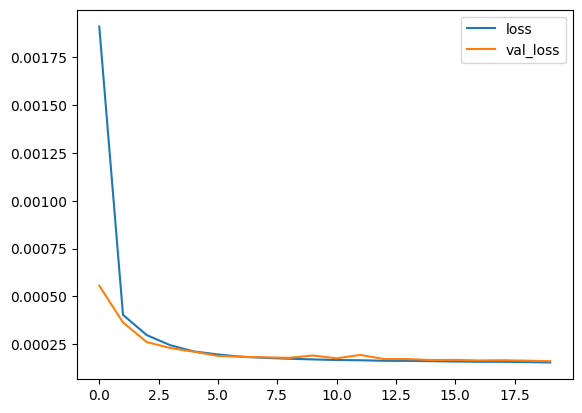

109/109 [==============================] - 0s 1ms/step


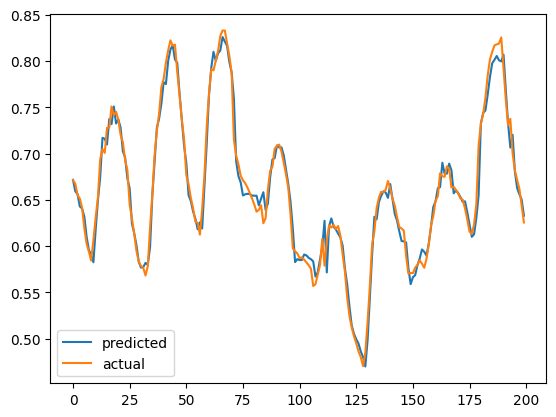

Mean Absolute Error over testing data: 0.0076902804276780205
and that averages to a 0.46 degrees error


In [19]:
# training, testing and plotting the results with the new dataset
train_test_plot(model9, optimizer=Adam(0.0001),
                train=data_to_xy9(train9, f, t),
                val=data_to_xy9(val9, f, t),
                test=data_to_xy9(test9, f, t),
                # epochs=50,
)

At last, by using the other features, the model still had a small increase in performance, being the best trained model on this work for the next-hour task, so far. This might be, then, a good approach to further improve the model, and even for the next-day prediction task.